# Initialization and requirements 

In [1]:
!pip install watson-machine-learning-client cloudant pydot graphviz --upgrade

    100% |████████████████████████████████| 942kB 1.4MB/s eta 0:00:01
Requirement already up-to-date: cloudant in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages
Requirement not upgraded as not directly required: pandas in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement not upgraded as not directly required: lomond in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement not upgraded as not directly required: requests in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement not upgraded as not directly required: certifi in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement not upgraded as not directly required: ibm-cos-sdk in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement not upgraded as not directly 

In [2]:
import keras
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import os

from watson_machine_learning_client import WatsonMachineLearningAPIClient

Using TensorFlow backend.
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
2019-01-16 11:05:36,680 - watson_machine_learning_client.wml_client_error - WARNING - Failure during scoring. (POST https://eu-de.ml.cloud.ibm.com/v3/wml_instances/c6cffbe7-484d-4ddc-ba18-11212d5417d8/deployments/812b36cc-9600-4f36-a40d-7a1881724dca/online)
Status code: 500, body: {"message": "Internal Server Error"}

2019-01-16 11:05:59,177 - watson_machine_learning_client.wml_client_error - WARNING - Failure during scoring. (POST https://eu-de.ml.cloud.ibm.com/v3/wml_instances/c6cffbe7-484d-4ddc-ba18-11212d5417d8/deploym

# Train classifier

### Load and prepare data 

In [3]:
# there are ten digits in MNIST
num_classes = 10

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between tran and test sets
(X_train, y_train_classes), (X_test, y_test_classes) = mnist.load_data()
print("X_train original shape", X_train.shape)
print("y_train original shape", y_train_classes.shape)


if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

11493376/11490434 [==============================] - 11s 1us/step
X_train original shape (60000, 28, 28)
y_train original shape (60000,)
X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [4]:
# convert class vectors to binary class matrices
y_train = to_categorical(y_train_classes, num_classes)
y_test = to_categorical(y_test_classes, num_classes)

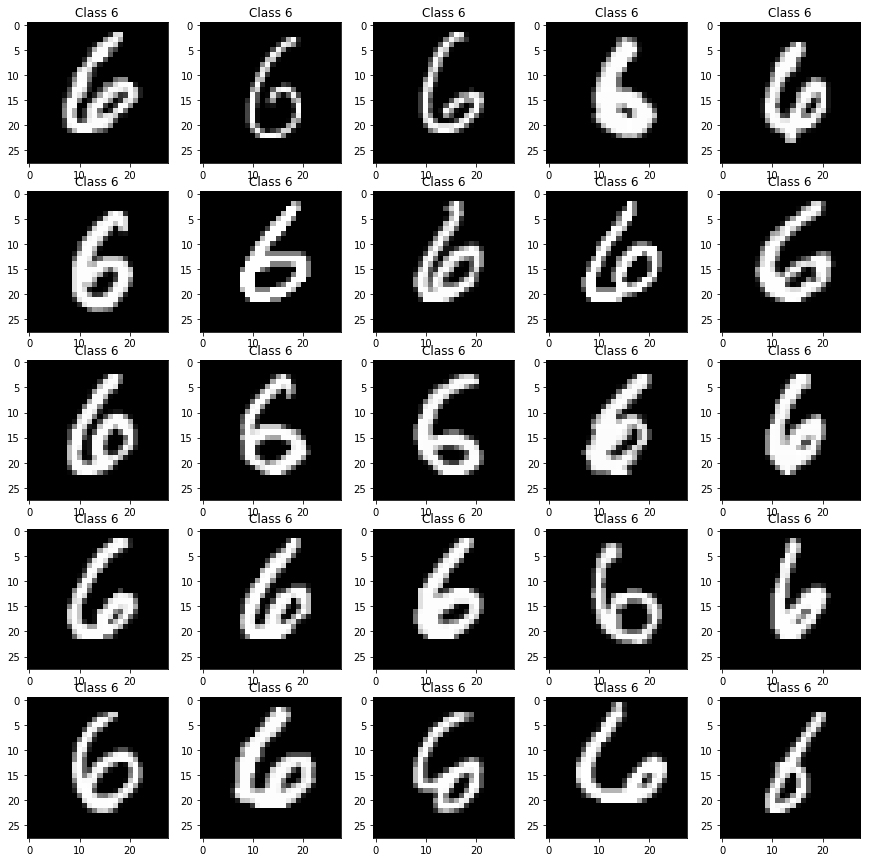

In [6]:
digit = 6
idx = np.where(y_train_classes == digit)[0]
plt.figure(figsize=(15,15))
for p, i in enumerate(idx[:25]):
    plt.subplot(5,5,p+1)
    plt.imshow(X_train[i].reshape((28,28)), cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train_classes[i]))

### Define Model

In [21]:
model = Sequential()

model.add( Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape) )

model.add( Conv2D(64, (3, 3), activation='relu') )

model.add( MaxPooling2D(pool_size=(2, 2)) )

model.add( Dropout(0.25) )

model.add( Flatten() )

model.add( Dense(128, activation='relu') )

model.add( Dropout(0.5) )

model.add( Dense(num_classes, activation='softmax') )

model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adadelta(),
    metrics=['accuracy']
)

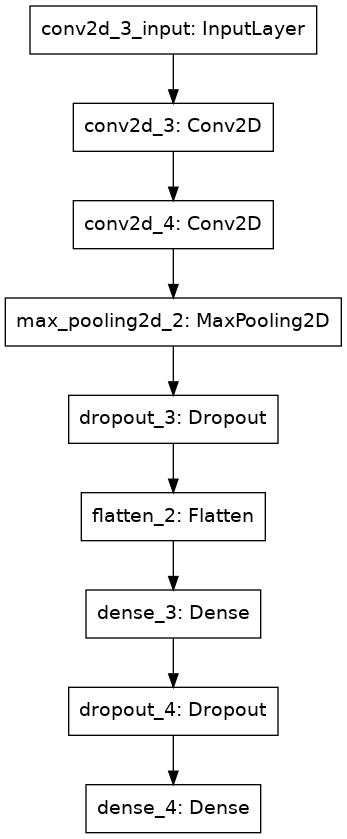

In [22]:
model_graph_file_name = 'keras_mnist_cnn.png'
keras.utils.plot_model(model, to_file=model_graph_file_name)
Image.open(model_graph_file_name)

### Train Model

In [23]:
batch_size = 128
epochs = 2

history = model.fit(
    X_train[:1000], y_train[:1000],
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, y_test),
)

print("Training history:" + str(history.history))

score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 1000 samples, validate on 10000 samples
Epoch 1/2
1000/1000 [==============================] - 28s 28ms/step - loss: 1.9651 - acc: 0.3250 - val_loss: 1.4014 - val_acc: 0.4984
Epoch 2/2
1000/1000 [==============================] - 30s 30ms/step - loss: 1.2219 - acc: 0.6090 - val_loss: 0.7940 - val_acc: 0.7995
Training history:{'loss': [1.9650897245407104, 1.221898515701294], 'acc': [0.32500000000000001, 0.60899999809265137], 'val_loss': [1.4014051994323731, 0.79403192644119258], 'val_acc': [0.49840000000000001, 0.79949999999999999]}
Test loss: 0.794031933498
Test accuracy: 0.7995


# Deploy Classifier

In [26]:
# First, the Keras model has to be stored in a HDF-5 (*.h5) file
model_file_name = 'kears_mnist_cnn.h5'
model.save(model_file_name)

# Then, the Kears model file has to be packaged into a gzipped tar archive
import os
model_deployment_artifact_name = model_file_name.replace('.h5','.tgz')
os.system("tar cvzf {} {}".format(model_deployment_artifact_name, model_file_name))

# see if everything worked out fine
!ls -alh

total 27M
drwxr-x--- 2 dsxuser dsxuser 4.0K Jan 15 16:34 .
drwx------ 1 dsxuser dsxuser 4.0K Jan 15 09:24 ..
-rw-r----- 1 dsxuser dsxuser  14M Jan 15 16:34 kears_mnist_cnn.h5
-rw-r----- 1 dsxuser dsxuser  13M Jan 15 16:34 kears_mnist_cnn.tgz
-rw-r----- 1 dsxuser dsxuser  27K Jan 15 16:31 keras_mnist_cnn.png


In [7]:
# @hidden_cell
wml_credentials = {
  "apikey": "FgZnhBSO9mn-XjOerW_1jPscEvJhVyTtfdw4J6jelLGI",
  "iam_apikey_description": "Auto generated apikey during resource-key operation for Instance - crn:v1:bluemix:public:pm-20:eu-de:a/cb770a601a994921ac2cc0ef1a667d99:c6cffbe7-484d-4ddc-ba18-11212d5417d8::",
  "iam_apikey_name": "auto-generated-apikey-cdbdcdec-65b1-4c0f-bd9d-25bbf278c618",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/cb770a601a994921ac2cc0ef1a667d99::serviceid:ServiceId-a928f8d5-e942-44ba-ad8e-d4212937ddbe",
  "instance_id": "c6cffbe7-484d-4ddc-ba18-11212d5417d8",
  "password": "81588135-18a2-45b1-8e77-12bc4e543ea8",
  "url": "https://eu-de.ml.cloud.ibm.com",
  "username": "cdbdcdec-65b1-4c0f-bd9d-25bbf278c618"
}

In [8]:
wmlc = WatsonMachineLearningAPIClient(wml_credentials)

In [29]:
meta_props={
    wmlc.repository.ModelMetaNames.AUTHOR_NAME: "Thomas Natschläger", 
    wmlc.repository.ModelMetaNames.NAME: "Simple CNN for MNIST data",
    wmlc.repository.ModelMetaNames.FRAMEWORK_NAME: "tensorflow",
    wmlc.repository.ModelMetaNames.FRAMEWORK_VERSION: "1.5",
    wmlc.repository.ModelMetaNames.RUNTIME_NAME: "python",
    wmlc.repository.ModelMetaNames.RUNTIME_VERSION: "3.5",
    wmlc.repository.ModelMetaNames.FRAMEWORK_LIBRARIES: [{'version': '2.1.3', 'name': 'keras'}]
}

In [ ]:
# And finally we can store the artifact (*.tgz) in the model repository
published_keras_cnn = wmlc.repository.store_model(
    model=model_deployment_artifact_name,
    meta_props=meta_props
)

In [ ]:
model_guid = wmlc.repository.get_model_uid(published_keras_cnn)
model_guid

In [ ]:
deployment_details = wmlc.deployments.create(
    model_guid, name = 'Deployment of ' + meta_props[wmlc.repository.ModelMetaNames.NAME]
)

In [11]:
# scoring_url = wmlc.deployments.get_scoring_url(deployment_details)
scoring_url = 'https://eu-de.ml.cloud.ibm.com/v3/wml_instances/c6cffbe7-484d-4ddc-ba18-11212d5417d8/deployments/b844041f-297a-4d7e-a408-df2f8eca9aa6/online'
scoring_url

'https://eu-de.ml.cloud.ibm.com/v3/wml_instances/c6cffbe7-484d-4ddc-ba18-11212d5417d8/deployments/b844041f-297a-4d7e-a408-df2f8eca9aa6/online'

# Test deployed model

In [12]:
def numpy_array_to_json_serializable(array):
    return [[[float(x)] for x in row] for row in array]

In [13]:
n=20
scoring_payload = {
    'values': [numpy_array_to_json_serializable(X_test[i]) for i in range(n)]
}
predictions = wmlc.deployments.score(scoring_url, scoring_payload)
[predictions['values'][i][1] for i in range(n)]

[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4]

In [14]:
list(y_test_classes[:n])

[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4]

In [ ]:
import json
cnn_model_uid = wmlc.repository.get_model_uid(published_keras_cnn)
cnn_model_details = wmlc.repository.get_details(cnn_model_uid)
print(json.dumps(cnn_model_details, indent=2))

# Apply classifier to new images (stored in Cloudant)

In [15]:
from cloudant.client import Cloudant
from cloudant.result import Result, ResultByKey
from cloudant.query import Query

# for handling base64 encoded images (needed to transmit a JPG efficiently in a JSON payload)
import base64
from io import BytesIO

# modules needed from PIL
from PIL import Image, ImageEnhance, ImageOps

# the Multi-dimensional image processing from scipy
from scipy import ndimage

# out good old friends
from matplotlib import pylab as plt
import numpy as np

# may be needed to display images
from IPython.display import display

In [30]:
class LocationOrder:
    """
    This comparison class can be used to orders locations (bounding boxes)
    found by ndimage.find_objects from top-left to bottom-right.
    """
    def __init__(self, loc, *args):
        self.y, self.x = loc
    def __eq__(self, other):
        return self.y == other.y and self.x == other.x
    def __lt__(self, other):
        above = self.y.stop < other.y.start
        if above:
            return True
        below = self.y.start > other.y.stop
        if below:
            return False
        return self.x.stop < other.x.start
    def __gt__(self, other):
        return not self < other and not self == other
    def __le__(self, other):
        return self < other or self == other
    def __ge__(self, other):
        return self > other or self == other
    def __ne__(self, other):
        return self != other
    
def area(loc):
    """
    Comput the area (==number of pixels) of a location found by ndimage.find_objects
    """
    y, x = loc
    dx = x.stop - x.start
    dy = y.stop - y.start
    return dx * dy

def cut_out_object(image, loc, digit_size=20, image_size=28):
    """
    Cut out the object at the location loc and return a square image of given width and border.
    
    This is done in the same way as the MNIST data is generated:
        The original black and white (bilevel) images from NIST were size normalized to fit in a 
        20x20 pixel box while preserving their aspect ratio. The resulting images contain grey
        levels as a result of the anti-aliasing technique used by the normalization algorithm. 
        The images were centered in a 28x28 image by computing the center of mass of the pixels,
        and translating the image so as to position this point at the center of the 28x28 field.
        See http://yann.lecun.com/exdb/mnist/.
        
    """
    
    # a location consits of the y (vertical/row) and x (horizontal/column) slice
    y, x = loc
    
    # build the bounding box
    bbox = (x.start, y.start, x.stop, y.stop)
    
    # number of pixels in x and y direction
    nx = x.stop - x.start
    ny = y.stop - y.start

    # the maximum
    n = max(nx, ny)
    
    # crop the object out of the image
    obj = image.crop(bbox)
    
    # generate a square of sie n x n which can hold the object
    square = Image.new('L', (n, n), 0)
    
    # now paste the object centered into the square
    square.paste(obj, (int((n - nx) / 2 + 0.5), int((n - ny) / 2 + 0.5)))
    
    # scale the square to digit_size x digit_size
    scaled = square.resize((digit_size, digit_size))
    cy, cx = ndimage.measurements.center_of_mass(np.array(scaled))
        
    # now we generate a final image of image_size x image_size ...
    final = Image.new('L', (image_size, image_size), 0)

    # ... where we paste in the scaled version of the object such that the center of mass is
    # at the center of the final image
    border = (int(image_size / 2 + 0.5 - cx), int(image_size / 2 + 0.5 - cy))
    final.paste(scaled, border)

    return final

def prediction_response(locations, images, predictions):
    fields = predictions['fields']
    i_prob = fields.index('probability')
    i_cls = fields.index('prediction_classes')
    i_pred = fields.index('prediction')
    certainty = []
    result = []
    for loc, img, value in zip(locations, images, predictions['values']):
        pred, cls, prob = value[i_pred], value[i_cls], value[i_prob]
        y, x = loc
        i = np.argmax(prob)
        result.append({
            'class': cls,
            'probabilities': prob,
            'prediction': pred,
            'certainty': prob[i],
            'image': img,
            'bbox': (x.start, y.start, x.stop, y.stop)
        })
    return result

In [31]:
# @hidden_cell
cloudant_credentials = {
  'password':"""9101eddac752e5c452b067d0b9566928deb96557e7f208c6b4a4fd0d275a8c8e""",
  'custom_url':'https://046c9f63-b007-416b-9037-43b7c9658cbb-bluemix.cloudant.com',
  'username':'046c9f63-b007-416b-9037-43b7c9658cbb-bluemix',
  'url':'https://undefined'
}

In [32]:
cloudant = Cloudant(
    cloudant_credentials['username'],
    cloudant_credentials['password'], 
    url=cloudant_credentials['custom_url'],
    connect=True
)

img_db  = cloudant['images']

In [35]:
# Select statement for document selection
# filter on one the date element to collect the subset
selector = {
    '_id':{'$gt': 0},
    'payload.d.datetime': {
        '$gt': '2019-01-14T00:00' # $gt: greater than 
    },
    'payload.d.label': '1-0'
}

# Create the query and get a handler
image_query = Query(
    img_db,
    selector=selector, 
    fields=['payload.d']
)

In [36]:
image_docs = sorted([d['payload']['d'] for d in image_query()['docs']], key=lambda d: d['timestamp'])
len(image_docs)

1

(320, 240)


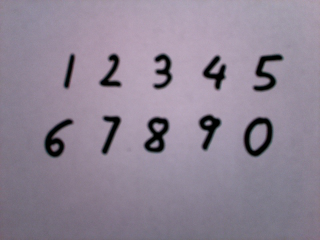

In [37]:
image_data = base64.b64decode(image_docs[0]['image'])
buffer = BytesIO(image_data)
image = Image.open(buffer)
print(image.size)
image

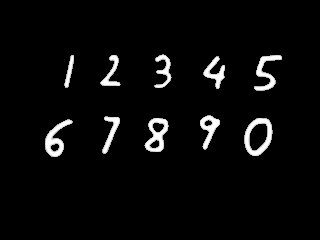

In [38]:
grayscale = image.convert('L')
inverted = ImageOps.autocontrast(ImageOps.invert(grayscale))
threshold = 150
thresholded = inverted.point(lambda x: 0 if x < threshold else x)
thresholded

In [39]:
# make binary mask
binary = np.array(thresholded) > 0

# label images
labeled, n_objects = ndimage.label(binary, structure=ndimage.generate_binary_structure(2,2))

# find rectangular boundig boxes around the labeled image
locations = ndimage.find_objects(labeled)

# keep only locations / bouding boxes with more then 100 pixels
locations = [o for o in locations if area(o) > 100]

# sort bounding boxes (locations) from top-left to bottom-right
locations = sorted(locations, key=LocationOrder)

In [40]:
# cut out the individual digit images from the thresholded image
digit_images = [cut_out_object(thresholded, loc) for loc in locations]

In [41]:
# prepare values for scoring with the mode. Note that the model expects a pixel range from 0.0 to 1.0
values = [numpy_array_to_json_serializable(np.array(img)/255) for img in digit_images]

In [42]:
# perform the scoring using the deployed model
predictions = wmlc.deployments.score(scoring_url, {'values': values})

In [44]:
# visualize the result
for resp in prediction_response(locations, digit_images, predictions):
    print("-"*80)
    display(resp['image'])
    print("classified as '{}' with certainty {}%".format(resp['class'], round(resp['certainty']*100,1)))

--------------------------------------------------------------------------------


classified as '1' with certainty 100.0%
--------------------------------------------------------------------------------


classified as '2' with certainty 100.0%
--------------------------------------------------------------------------------


classified as '3' with certainty 100.0%
--------------------------------------------------------------------------------


classified as '4' with certainty 99.8%
--------------------------------------------------------------------------------


classified as '5' with certainty 100.0%
--------------------------------------------------------------------------------


classified as '6' with certainty 98.7%
--------------------------------------------------------------------------------


classified as '7' with certainty 100.0%
--------------------------------------------------------------------------------


classified as '8' with certainty 100.0%
--------------------------------------------------------------------------------


classified as '9' with certainty 100.0%
--------------------------------------------------------------------------------


classified as '0' with certainty 100.0%


# Deployable function with preprocessing

In [95]:
import io

params = {
    'wml_credentials' : wml_credentials,
    'model_scoring_url' : scoring_url,
    'threshold': 150
}

def handwritten_digit_classification(params=params):
    
    import subprocess
    subprocess.check_output( "pip install Pillow --user", stderr=subprocess.STDOUT, shell=True)
    
    import base64, io
    import numpy as np
    from PIL import Image, ImageEnhance, ImageOps
    from scipy import ndimage
        
    class LocationOrder:
        """
        This comparison class can be used to orders locations (bounding boxes)
        found by ndimage.find_objects from top-left to bottom-right.
        """
        def __init__(self, loc, *args):
            self.y, self.x = loc
        def __eq__(self, other):
            return self.y == other.y and self.x == other.x
        def __lt__(self, other):
            above = self.y.stop < other.y.start
            if above:
                return True
            below = self.y.start > other.y.stop
            if below:
                return False
            return self.x.stop < other.x.start
        def __gt__(self, other):
            return not self < other and not self == other
        def __le__(self, other):
            return self < other or self == other
        def __ge__(self, other):
            return self > other or self == other
        def __ne__(self, other):
            return self != other
    
    def area(loc):
        """
        Comput the area (==number of pixels) of a location found by ndimage.find_objects
        """
        y, x = loc
        dx = x.stop - x.start
        dy = y.stop - y.start
        return dx * dy

    def numpy_array_to_json_serializable(array):
        return [[[float(x)] for x in row] for row in array]

    def cut_out_object(image, loc, digit_size=20, image_size=28):
        """
        Cut out the object at the location loc and return a square image of given width and border.

        This is done in the same way as the MNIST data is generated:
            The original black and white (bilevel) images from NIST were size normalized to fit in a 
            20x20 pixel box while preserving their aspect ratio. The resulting images contain grey
            levels as a result of the anti-aliasing technique used by the normalization algorithm. 
            The images were centered in a 28x28 image by computing the center of mass of the pixels,
            and translating the image so as to position this point at the center of the 28x28 field.
            See http://yann.lecun.com/exdb/mnist/.

        """

        # a location consits of the y (vertical/row) and x (horizontal/column) slice
        y, x = loc

        # build the bounding box
        bbox = (x.start, y.start, x.stop, y.stop)

        # number of pixels in x and y direction
        nx = x.stop - x.start
        ny = y.stop - y.start

        # the maximum
        n = max(nx, ny)

        # crop the object out of the image
        obj = image.crop(bbox)

        # generate a square of sie n x n which can hold the object
        square = Image.new('L', (n, n), 0)

        # now paste the object centered into the square
        square.paste(obj, (int((n - nx) / 2 + 0.5), int((n - ny) / 2 + 0.5)))

        # scale the square to digit_size x digit_size
        scaled = square.resize((digit_size, digit_size))
        cy, cx = ndimage.measurements.center_of_mass(np.array(scaled))

        # now we generate a final image of image_size x image_size ...
        final = Image.new('L', (image_size, image_size), 0)

        # ... where we paste in the scaled version of the object such that the center of mass is
        # at the center of the final image
        border = (int(image_size / 2 + 0.5 - cx), int(image_size / 2 + 0.5 - cy))
        final.paste(scaled, border)

        return final

    def prediction_response(locations, images, predictions):
        fields = predictions['fields']
        i_prob = fields.index('probability')
        i_cls = fields.index('prediction_classes')
        i_pred = fields.index('prediction')
        certainty = []
        result = []
        for loc, img, value in zip(locations, images, predictions['values']):
            pred, cls, prob = value[i_pred], value[i_cls], value[i_prob]
            y, x = loc
            i = np.argmax(prob)
            result.append({
                'class': cls,
                'probabilities': prob,
                'prediction': pred,
                'certainty': prob[i],
                'image': img,
                'bbox': (x.start, y.start, x.stop, y.stop)
            })
        return result

    def b64_encoded(img):
        b = io.BytesIO()
        img.save(b, format='JPEG')
        return base64.b64encode(b.getvalue()).decode('ascii')

    def score_one_image(b64_image):
        """
        Score all the objects found in one image
        """
        from watson_machine_learning_client import WatsonMachineLearningAPIClient
        wmlc = WatsonMachineLearningAPIClient( params["wml_credentials"] )
            
        # decode the b64 image to get raw binary image data
        image_data = base64.b64decode(b64_image)
        
        # convert into a file like object
        buffer = io.BytesIO(image_data)
        
        # read the file using PIL
        image = Image.open(buffer)
        
        # convert to gray scale
        grayscale = image.convert('L')
        
        # invert the image and enhance contrast
        inverted = ImageOps.autocontrast(ImageOps.invert(grayscale))
        
        # set all pixel values to zero below the threshold
        thresholded = inverted.point(lambda x: 0 if x < params['threshold'] else x)

        # make binary mask
        binary = np.array(thresholded) > 0

        # label images
        labeled, n_objects = ndimage.label(binary, structure=ndimage.generate_binary_structure(2,2))

        # find rectangular boundig boxes around the labeled image
        locations = ndimage.find_objects(labeled)

        # keep only locations / bouding boxes with more then 100 pixels
        locations = [o for o in locations if area(o) > 100]

        # sort bounding boxes (locations) from top-left to bottom-right
        locations = sorted(locations, key=LocationOrder)

        # cut out the individual digit images from the thresholded image
        digit_images = [cut_out_object(thresholded, loc) for loc in locations]

        
        # prepare values for scoring with the mode. Note that the model expects a pixel range from 0.0 to 1.0
        values = [numpy_array_to_json_serializable(np.array(img)/255) for img in digit_images]

        # perform the scoring using the deployed model
        predictions = wmlc.deployments.score(params['model_scoring_url'], {'values': values})

        # cut out the individual digit images from the thresholded image
        b64_digit_images = [b64_encoded(img) for img in digit_images]
        
        # return a reformate version of the response
        return prediction_response(locations, b64_digit_images, predictions)
    
    def do_scoring(payload):
        
        # the response will be a list of prediction results for each image
        # Note, that each image may contain several digits.
        response = []

        # values is a list of base64 encoded images
        for b64_image in payload['values']:
            response.append(score_one_image(b64_image))
            
        return response
    
    def score(payload):
        try:
            return do_scoring(payload)
        except Exception as e:
            return { "error" : repr( e ) }
        
    return score

In [96]:
b = io.BytesIO()
image.save(b, format='JPEG')
b64 = base64.b64encode(b.getvalue())

In [97]:
response = handwritten_digit_classification()({'values': [b64, b64]})

In [98]:
import json
J = json.dumps(response)

In [99]:
#
# Store the deployable function in your Watson Machine Learning repository
#
meta_props = {
    wmlc.repository.FunctionMetaNames.NAME : 'Deployable Function for digit classification'
}
function_details = wmlc.repository.store_function(meta_props=meta_props, function=handwritten_digit_classification)

No RUNTIME_UID passed. Creating default runtime... SUCCESS

Successfully created default runtime with uid: 28dc8747-9fc2-4fe7-98c1-e65291ba7ee7


In [100]:
wmlc.repository.list_functions()

------------------------------------  --------------------------------------------  ------------------------  ------
GUID                                  NAME                                          CREATED                   TYPE
7cc098b7-1f92-49da-9716-645a1157c22f  Deployable Function for digit classification  2019-01-16T11:12:12.376Z  python
709a1f58-ba6d-4cdf-a637-446ec92854cc  Deployable Function for digit classification  2019-01-16T11:07:24.944Z  python
03777394-b91c-43d5-a601-0113c053d032  Deployable Function for digit classification  2019-01-16T11:00:51.275Z  python
faef1867-6fca-4d85-9894-247e60b3addd  Deployable Function for digit classification  2019-01-15T19:30:18.936Z  python
3d752ebf-85a8-4a53-bdd8-440112387e11  Deployable Function for digit classification  2019-01-15T19:27:56.274Z  python
e247ef2e-783d-444d-b58c-8083a7d9681c  Deployable Function for digit classification  2019-01-15T19:22:16.541Z  python
1dbd9d50-b362-4082-a4a1-96211f391d1d  Deployable Function for digi

In [101]:
#
# Deploy the stored function
#
artifact_uid = function_details["metadata"]["guid"]
function_deployment_details = wmlc.deployments.create(artifact_uid=artifact_uid, name="Deployed function for digit classification (MNIST)")



#######################################################################################

Synchronous deployment creation for uid: '7cc098b7-1f92-49da-9716-645a1157c22f' started

#######################################################################################


INITIALIZING
DEPLOY_IN_PROGRESS..
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='0bacdc42-4409-4170-bcff-1eb12bdf1341'
------------------------------------------------------------------------------------------------




In [102]:
# Get the endpoint URL of the function deployment just created
function_deployment_endpoint_url = wmlc.deployments.get_scoring_url(function_deployment_details)
function_deployment_endpoint_url

'https://eu-de.ml.cloud.ibm.com/v3/wml_instances/c6cffbe7-484d-4ddc-ba18-11212d5417d8/deployments/0bacdc42-4409-4170-bcff-1eb12bdf1341/online'

In [103]:
result = wmlc.deployments.score(function_deployment_endpoint_url, {'values': [b64, b64]} )
result

[[{'bbox': [64, 55, 74, 88],
   'certainty': 0.9999829530715942,
   'class': 1,
   'image': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/wAALCAAcABwBAREA/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/9oACAEBAAA/APn+rmlaZc6zq1rptmu64uZViTIOASepxngdSewBp+uaYdF8QalpRlExsrqW2MgXG/Y5XOO2cVQor0X4H2D3nxRsJhs8uzimuJN3ddhUY99zr+tcPq+oNq2t3+pMnltd3Ek5TOdpdi2M9+tUqK9V+GepL4c+HXjnXFuY1uvKht7dEZTKjsWUPtP8OXH12t6V5VRRRRRX/9k=',
   'prediction': [2.463363557581033e-07,
    0.9999829530715942,
    6.016413180987001e-07,
    4.3107128533392824e-08,
    2.0051268165843794e-06,
    5.180974653740122e-07,
    4.247641243182443e-07,
    9.985299584513996e-06,
    3.172666538375779e-06,
    1.50